In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.image as mpimg

import imagehash

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from mlxtend.plotting import plot_confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
train_path = "./dataset/train"
test_path = "./dataset/test"
size_images=256

In [3]:
train_ds = image_dataset_from_directory(
    train_path,
    # label_mode='int',
    shuffle=True,
    label_mode='categorical',
    seed=123,
    image_size=(size_images,size_images),
    batch_size=32
)

test_ds = image_dataset_from_directory(
    test_path,
    # label_mode='int',
    shuffle=True,
    label_mode='categorical',
    seed=123,
    image_size=(size_images,size_images),
    batch_size=32
)

for x, y in train_ds.take(1):
  print(x.shape, y.shape)
    
for x, y in test_ds.take(1):
  print(x.shape, y.shape)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
(32, 256, 256, 3) (32, 4)
(32, 256, 256, 3) (32, 4)


In [4]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_ds).numpy())

Number of training batches: 179
Number of testing batches: 41


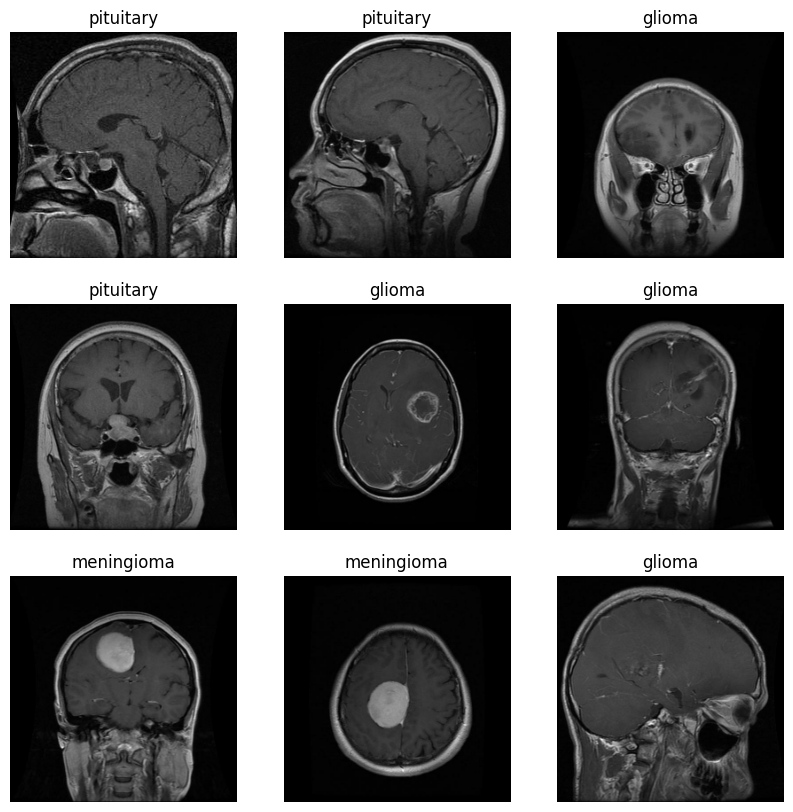

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

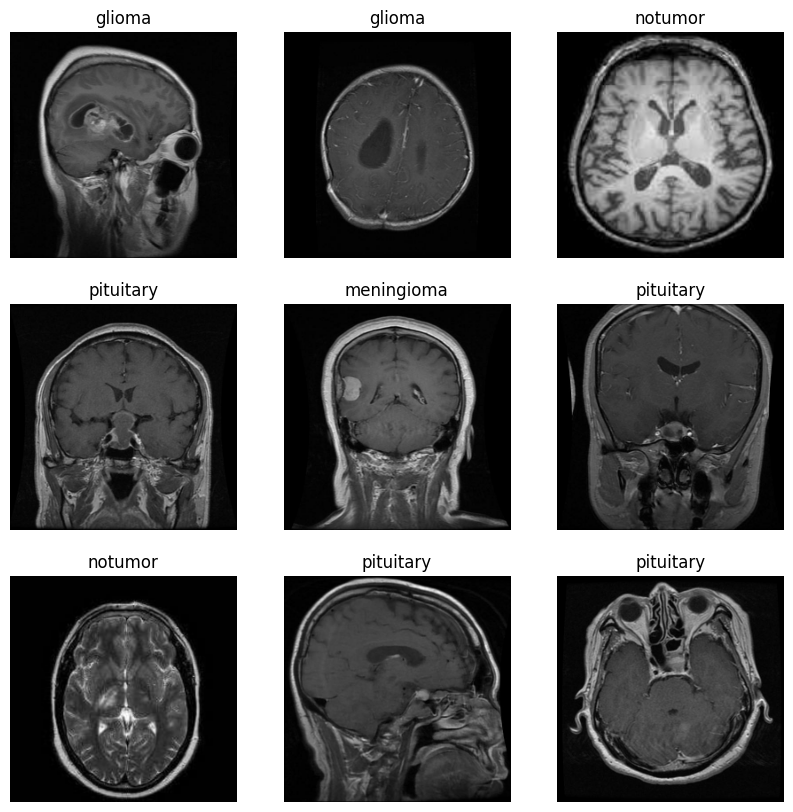

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_ds).numpy())

Number of training batches: 179
Number of testing batches: 41


In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
num_classes = len(class_names)

In [13]:
from tensorflow.keras.applications import InceptionResNetV2
base_model=InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# base_model.summary()

In [16]:
from tensorflow.keras import layers
# model = tf.keras.models.Sequential([
#     base_model,
    
#     layers.Flatten(),
    
#     layers.Dense(256,activation='relu'),
#     layers.Dense(128,activation='relu'),
#     layers.Dense(64,activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4,activation='softmax'),
# ])
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size_images, size_images, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

C:\Users\anura\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_203 (Conv2D)                  │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_204 (Conv2D)                  │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     125,960,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,054,276 (480.86 MB)

 Trainable params: 126,054,276 (480.86 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [19]:
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential(model.layers[:-1])

new_output = Dense(4, activation='softmax')
model.add(new_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_203 (Conv2D)                  │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_204 (Conv2D)                  │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     125,960,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,054,276 (480.86 MB)

 Trainable params: 126,054,276 (480.86 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs=10
history = model.fit(
  normalized_ds,
  validation_data=normalized_test_ds,
  epochs=epochs
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.5743 - loss: 1.3220 - val_accuracy: 0.7536 - val_loss: 0.5720
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.9014 - loss: 0.2613 - val_accuracy: 0.8970 - val_loss: 0.2664
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9642 - loss: 0.0958 - val_accuracy: 0.9451 - val_loss: 0.1601
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9856 - loss: 0.0448 - val_accuracy: 0.9375 - val_loss: 0.2340
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9935 - loss: 0.0243 - val_accuracy: 0.9237 - val_loss: 0.2499
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9930 - loss: 0.0226 - val_accuracy: 0.9519 - val_loss: 0.2168
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0.9641 - val_loss: 0.1819
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9971 - loss: 0.0089 - val_accu

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_203 (Conv2D)                  │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_204 (Conv2D)                  │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     125,960,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,162,830 (1.41 GB)

 Trainable params: 126,054,276 (480.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 252,108,554 (961.72 MB)

In [24]:
# model.save("v1model.h5")

In [356]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# Save the TensorFlow Lite model to disk
# open('your_model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\anura\AppData\Local\Temp\tmp54_k4_um\assets


INFO:tensorflow:Assets written to: C:\Users\anura\AppData\Local\Temp\tmp54_k4_um\assets


Saved artifact at 'C:\Users\anura\AppData\Local\Temp\tmp54_k4_um'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_8887')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2529832140624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832139280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832138704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832124880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832137936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832125072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832125456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832126416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832126992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2529832130064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

504221332

In [ ]:
normalized_test_ds

In [25]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 4)


In [26]:
score = model.evaluate(normalized_test_ds, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26382866501808167
Test accuracy: 0.9412662386894226


<Figure size 640x480 with 0 Axes>

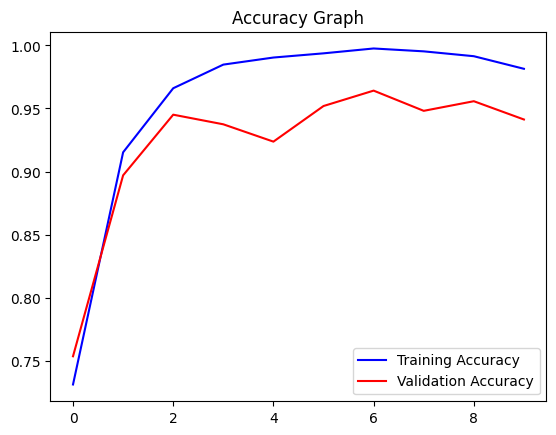

<Figure size 640x480 with 0 Axes>

In [27]:

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

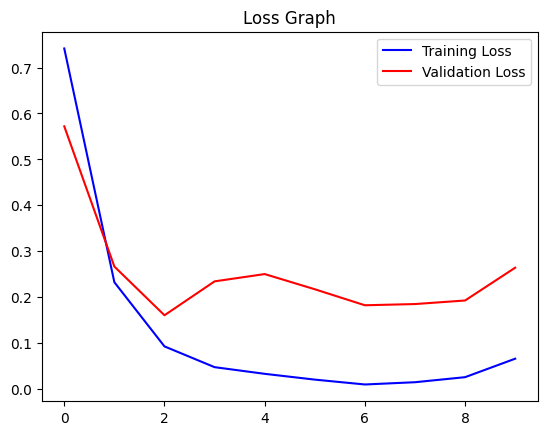

In [28]:

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [29]:
import tensorflow as tf
y_true = []
y_pred = []
for x,y in normalized_test_ds.take(4):
  # y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(model.predict(x))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

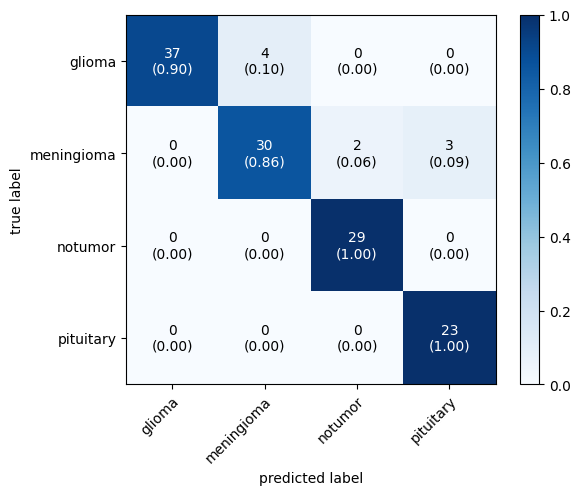

In [30]:
mat = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(conf_mat = mat,show_absolute=True,show_normed=True,colorbar=True,class_names=class_names)

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_macro = f1_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='macro') 
f1_micro = f1_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='micro') 

In [33]:
print("f1 macro score",f1_macro ,"\nf2 micro score" , f1_micro)

f1 macro score 0.9309313357450004 
f2 micro score 0.9296875


In [34]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, _, __ = score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
precision = np.round_(precision, decimals = 3) 
recall = np.round_(recall, decimals = 3) 
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

precision: [1.    0.882 0.935 0.885]
recall: [0.902 0.857 1.    1.   ]


In [35]:
print("Precision and Recall of Each class")
print("ClassName            | precision | recall")
print("---------------------+-----------+-------")
for i in range(4):
    print(class_names[i].ljust(len("Alternaria leaf spot")," "),"|", str(precision[i]).ljust(len("precision"), " "),"|", recall[i])

Precision and Recall of Each class
ClassName            | precision | recall
---------------------+-----------+-------
glioma               | 1.0       | 0.902
meningioma           | 0.882     | 0.857
notumor              | 0.935     | 1.0
pituitary            | 0.885     | 1.0


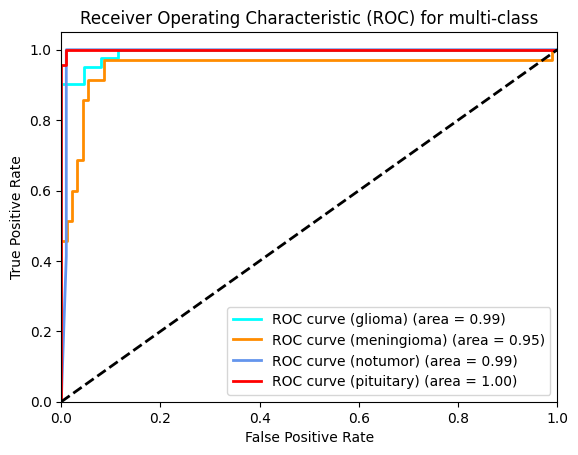

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# y_true = pred_test_batch_result
y_scores = y_pred

n_classes = 4
y_bin = label_binarize(y_true, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve ({0}) (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()
